In [16]:
# Model design
import agentpy as ap
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import numpy as np
from scipy.ndimage import label

In [10]:
# If agentpy is not installed, uncomment this
# ! pip install agentpy

In [11]:

'''
Rules of the system:
1. A burning tree becomes an empty site
2. A green tree becomes burning if at least one of its neighbours is burning
3. At an empty site, a tree grows with the probability p
4. A tree without a burning neighbour becomes a burning tree at any time step with the probability f ('lightning')

Modifications needed:
1. Do not automatically start the burning
2. Add a condition where a tree starts growing
3. Adjust probabilities
4. Do not stop the animation
Hello :)
'''

"\nRules of the system:\n1. A burning tree becomes an empty site\n2. A green tree becomes burning if at least one of its neighbours is burning\n3. At an empty site, a tree grows with the probability p\n4. A tree without a burning neighbour becomes a burning tree at any time step with the probability f ('lightning')\n\nModifications needed:\n1. Do not automatically start the burning\n2. Add a condition where a tree starts growing\n3. Adjust probabilities\n4. Do not stop the animation\nHello :)\n"

In [72]:

class ForestModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        n_trees = int(self.p['Tree density'] * (self.p.size**2))
        trees = self.agents = ap.AgentList(self, n_trees)

        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.forest.add_agents(trees, random=True, empty=True)

        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Burning, 2: Empty
        self.agents.condition = 0        
        # Amount of lightning
        self.f = self.p['probability of lightning']

        # Ratio between f and p
        self.p_over_f = self.p['p_over_f']

        # Assign value to p
        self.growth = self.f * self.p_over_f

        # Start a fire from the left side of the grid
        # unfortunate_trees = self.forest.agents[0:self.p.size, 0:2]
        # unfortunate_trees.condition = 1

        
        self.tree_counts = []  # Initialize list to store number of trees
        self.cluster_counts = []
        self.cluster_size = []


    def count_fire_clusters(self):
        # Build 2D array of conditions
        grid_state = np.full(self.forest.shape, 2,dtype=np.int8)
        for agent in self.agents:
            x, y = self.forest.positions[agent]
            grid_state[x, y] = int(agent.condition)

        # Mask the target state (1 = burning, 0 = tree, etc.)
        mask = (grid_state == 1)

        # Identify clusters of healthy trees (0)
        structure = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=int)  # 4-connected
        labeled, num = label(mask, structure=structure)

        if num == 0:
            return 0, []
        counts = np.bincount(labeled.ravel())[1:]
        return num, counts
    
    # def count_fire_clusters(self):
    #     """Count the number of connected clusters of burning trees (condition == 1)."""
    #     burning_trees = self.agents.select(self.agents.condition == 1)
    #     if len(burning_trees) == 0:
    #         return 0, []
        
    #     burning_ids = set(a.id for a in burning_trees)
    #     visited = set()
    #     #clusters = 0
    #     sizes_clusters = []

    #     for tree in burning_trees:
    #         tid = tree.id
    #         if tree in visited:
    #             continue

    #         # New cluster found
    #         size = 0
    #         #clusters += 1
    #         stack = [tree]
    #         visited.add(tree)

    #         while stack:
    #             current = stack.pop()
    #             size += 1
    #             for neighbor in self.forest.neighbors(current):
    #                 nid = neighbor.id
    #                 #if neighbor.condition == 1 and neighbor not in visited:
    #                 if neighbor.condition != 2 and nid not in visited:
    #                     visited.add(neighbor)
    #                     stack.append(neighbor)
    #         sizes_clusters.append(size)

    #     return len(sizes_clusters), sizes_clusters
    
    # def count_clusters(self):
    #     """
    #     Count number of separate burned tree clusters.
    #     """
    #     burned_trees = self.agents.select(self.agents.condition == 2)
        
    #     if len(burned_trees) == 0:
    #         return 0
        
    #     burning_trees = self.agents.select(self.agents.condition == 1)
    #     for tree in burning_trees:
    #         for neighbor in self.forest.neighbors(tree):
    #             if neighbor.condition == 1:
    #                 neighbor.condition = 1 # Neighbor starts burning
    #     visited = set()
    #     num_clusters = 0
        
    #     for tree in burned_trees:
    #         if tree.id not in visited:
    #             # Found a new cluster, do BFS to mark all connected trees
    #             num_clusters += 1
    #             queue = deque([tree])
    #             visited.add(tree.id)
                
    #             while queue:
    #                 current = queue.popleft()
                    
    #                 for neighbor in self.forest.neighbors(current):
    #                     if neighbor.id not in visited and neighbor.condition == 2:
    #                         visited.add(neighbor.id)
    #                         queue.append(neighbor)
        
    #     return num_clusters    


    def step(self):

        # Select burning trees
        burning_trees = self.agents.select(self.agents.condition == 1)

        # Select empty lots
        no_trees = self.agents.select(self.agents.condition == 2)

        # Select healthy trees
        healthy_trees = self.agents.select(self.agents.condition == 0)

        # Add lighting
        for tree in healthy_trees:
            if random.random() < self.f:
                tree.condition = 1



        # Spread fire
        for tree in burning_trees:
            #added
            fid = getattr(tree, 'fire_id', None)
            for neighbor in self.forest.neighbors(tree):
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            tree.condition = 2 # Tree burns out

        for tree in no_trees:
            if random.random() < self.growth:
                tree.condition = 0


        nr_trees = len(self.agents.select(self.agents.condition == 0))
        self.tree_counts.append(nr_trees)
        
        #store clusters
        num_clusters, cluster_size = self.count_fire_clusters()
        self.cluster_counts.append(num_clusters)
        self.cluster_size.append(cluster_size)





    def end(self):

        # Document a measure at the end of the simulation
        burned_trees = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of burned trees',
                    burned_trees / len(self.agents))

In [70]:
# Define parameters

parameters = {
    'Tree density': 0.5, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 200,
    'probability of lightning': 0.0001,
    'p_over_f': 100 # assign a ratio to ensure that f << p
}

Completed: 200 steps
Run time: 0:00:00.362870
Simulation finished
Completed: 200 steps
Run time: 0:00:00.348913
Simulation finished
Completed: 200 steps
Run time: 0:00:00.330610
Simulation finished
Completed: 200 steps
Run time: 0:00:00.365561
Simulation finished
Completed: 200 steps
Run time: 0:00:00.445842
Simulation finished
Completed: 200 steps
Run time: 0:00:00.453292
Simulation finished
Completed: 200 steps
Run time: 0:00:00.439819
Simulation finished
Completed: 200 steps
Run time: 0:00:00.430183
Simulation finished
Completed: 200 steps
Run time: 0:00:00.475933
Simulation finished
Completed: 200 steps
Run time: 0:00:00.640117
Simulation finished
Completed: 200 steps
Run time: 0:00:00.551498
Simulation finished
Completed: 200 steps
Run time: 0:00:00.587269
Simulation finished
Completed: 200 steps
Run time: 0:00:00.754965
Simulation finished
Completed: 200 steps
Run time: 0:00:00.770037
Simulation finished
Completed: 200 steps
Run time: 0:00:00.745054
Simulation finished
Completed:

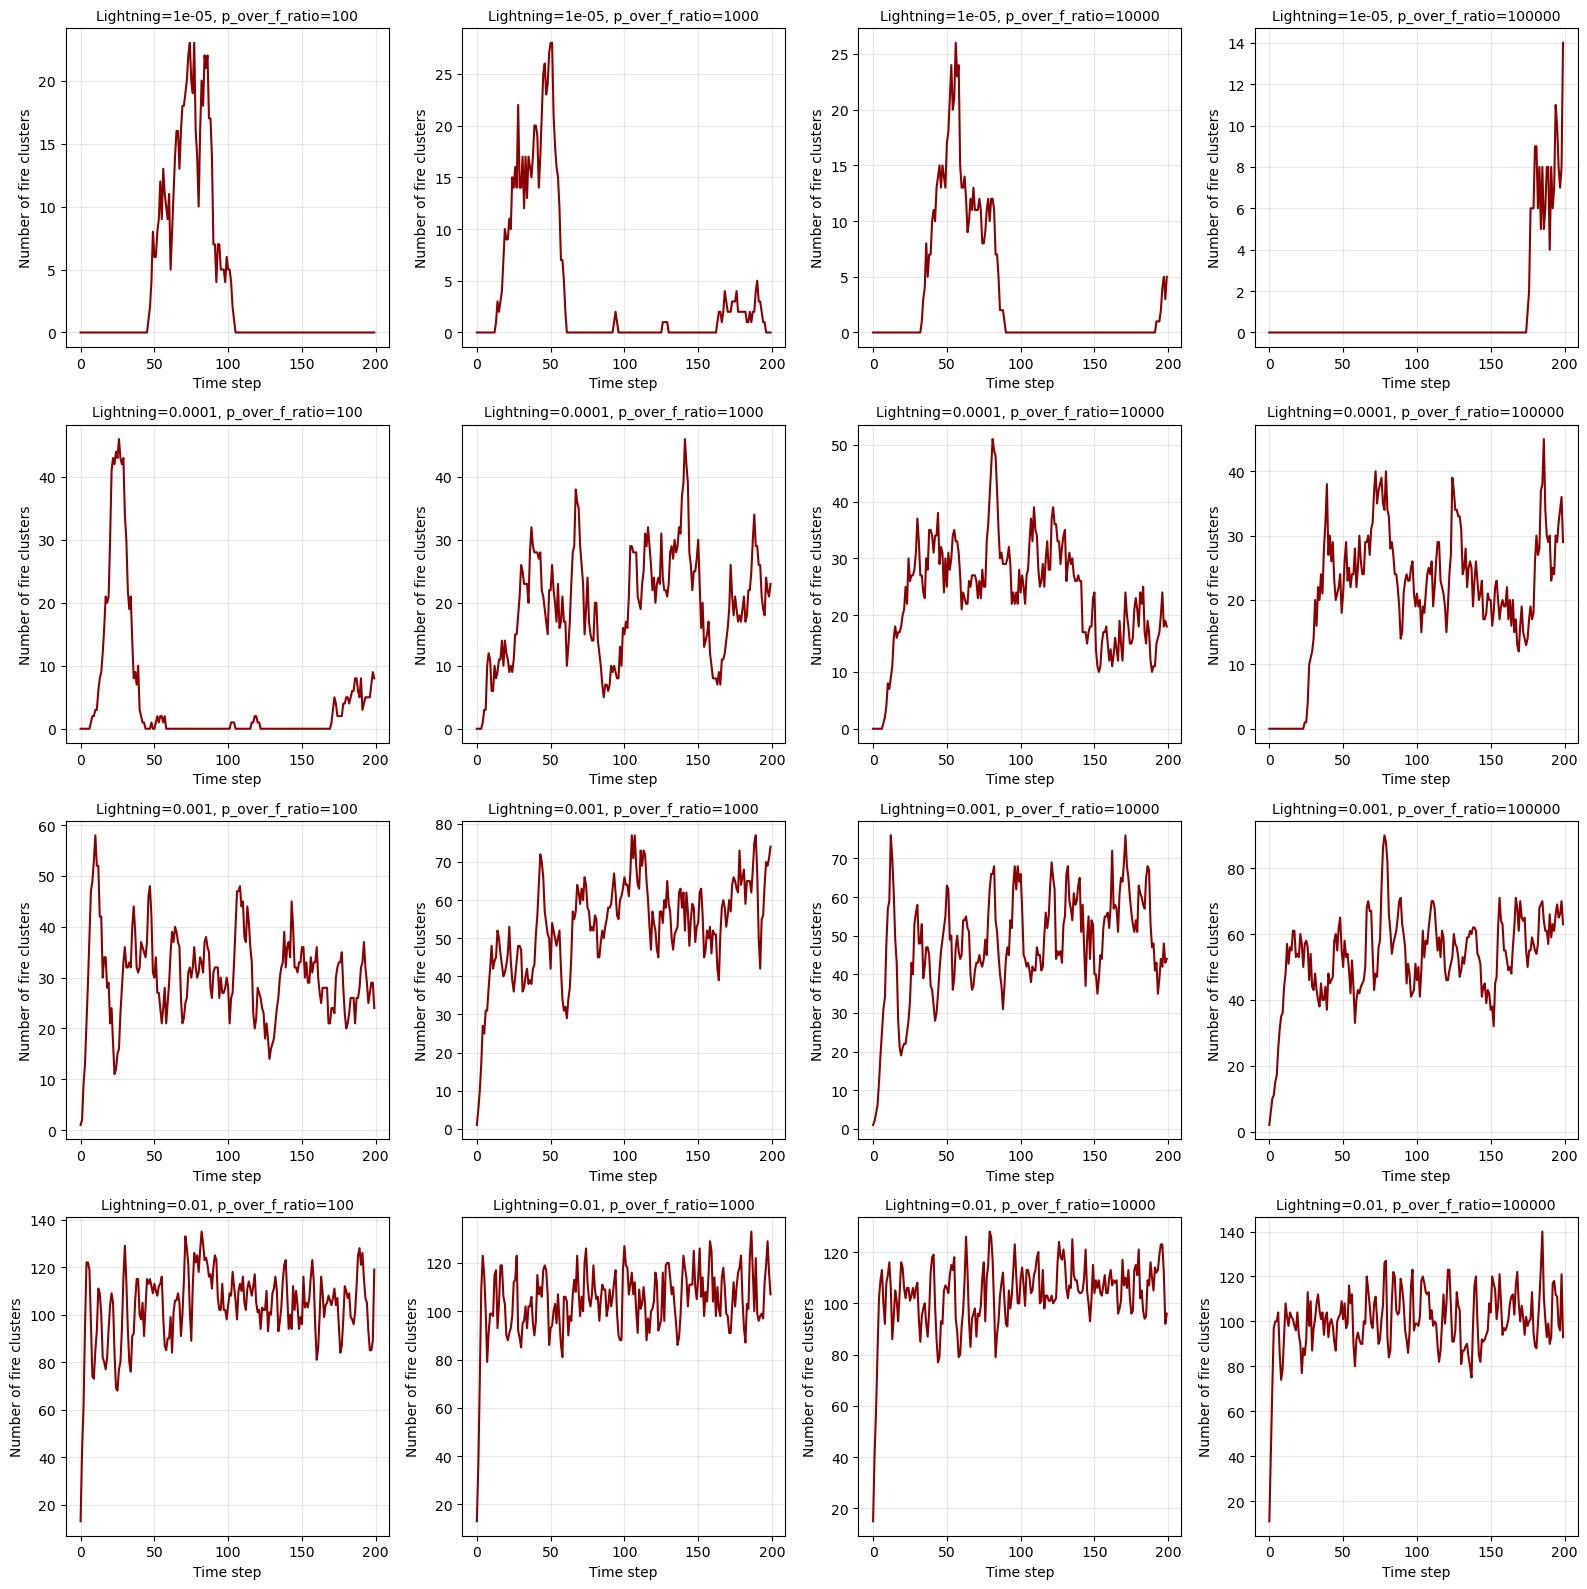

In [73]:
import matplotlib.pyplot as plt
parameters['steps'] = 200
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
list_lightning = [0.00001, 0.0001, 0.001, 0.01]
list_p_over_f = [100, 1000, 10000, 100000]
for i, f in enumerate(list_lightning):
    for j, p in enumerate(list_p_over_f):
        ax = axs[i, j]  # select subplot
        parameters['probability of lightning'] = f
        parameters['p_over_f'] = p
        model = ForestModel(parameters)
        model.run()
    
        ax.plot(model.cluster_counts, color='darkred', lw=1.5)
        ax.set_title(f"Lightning={f}, p_over_f_ratio={p}", fontsize=10)
        ax.set_xlabel('Time step')
        ax.set_ylabel('Number of fire clusters')
        ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Completed: 2000 steps
Run time: 0:00:03.555669
Simulation finished
Completed: 2000 steps
Run time: 0:00:03.421610
Simulation finished
Completed: 2000 steps
Run time: 0:00:03.416868
Simulation finished
Completed: 2000 steps
Run time: 0:00:02.972784
Simulation finished
Completed: 2000 steps
Run time: 0:00:03.544560
Simulation finished
Completed: 2000 steps
Run time: 0:00:04.109658
Simulation finished
Completed: 2000 steps
Run time: 0:00:03.606802
Simulation finished
Completed: 2000 steps
Run time: 0:00:04.296476
Simulation finished
Completed: 2000 steps
Run time: 0:00:06.009996
Simulation finished
Completed: 2000 steps
Run time: 0:00:06.306541
Simulation finished
Completed: 2000 steps
Run time: 0:00:05.794807
Simulation finished
Completed: 2000 steps
Run time: 0:00:05.978899
Simulation finished
Completed: 2000 steps
Run time: 0:00:08.762027
Simulation finished
Completed: 2000 steps
Run time: 0:00:08.876539
Simulation finished
Completed: 2000 steps
Run time: 0:00:11.694561
Simulation fini

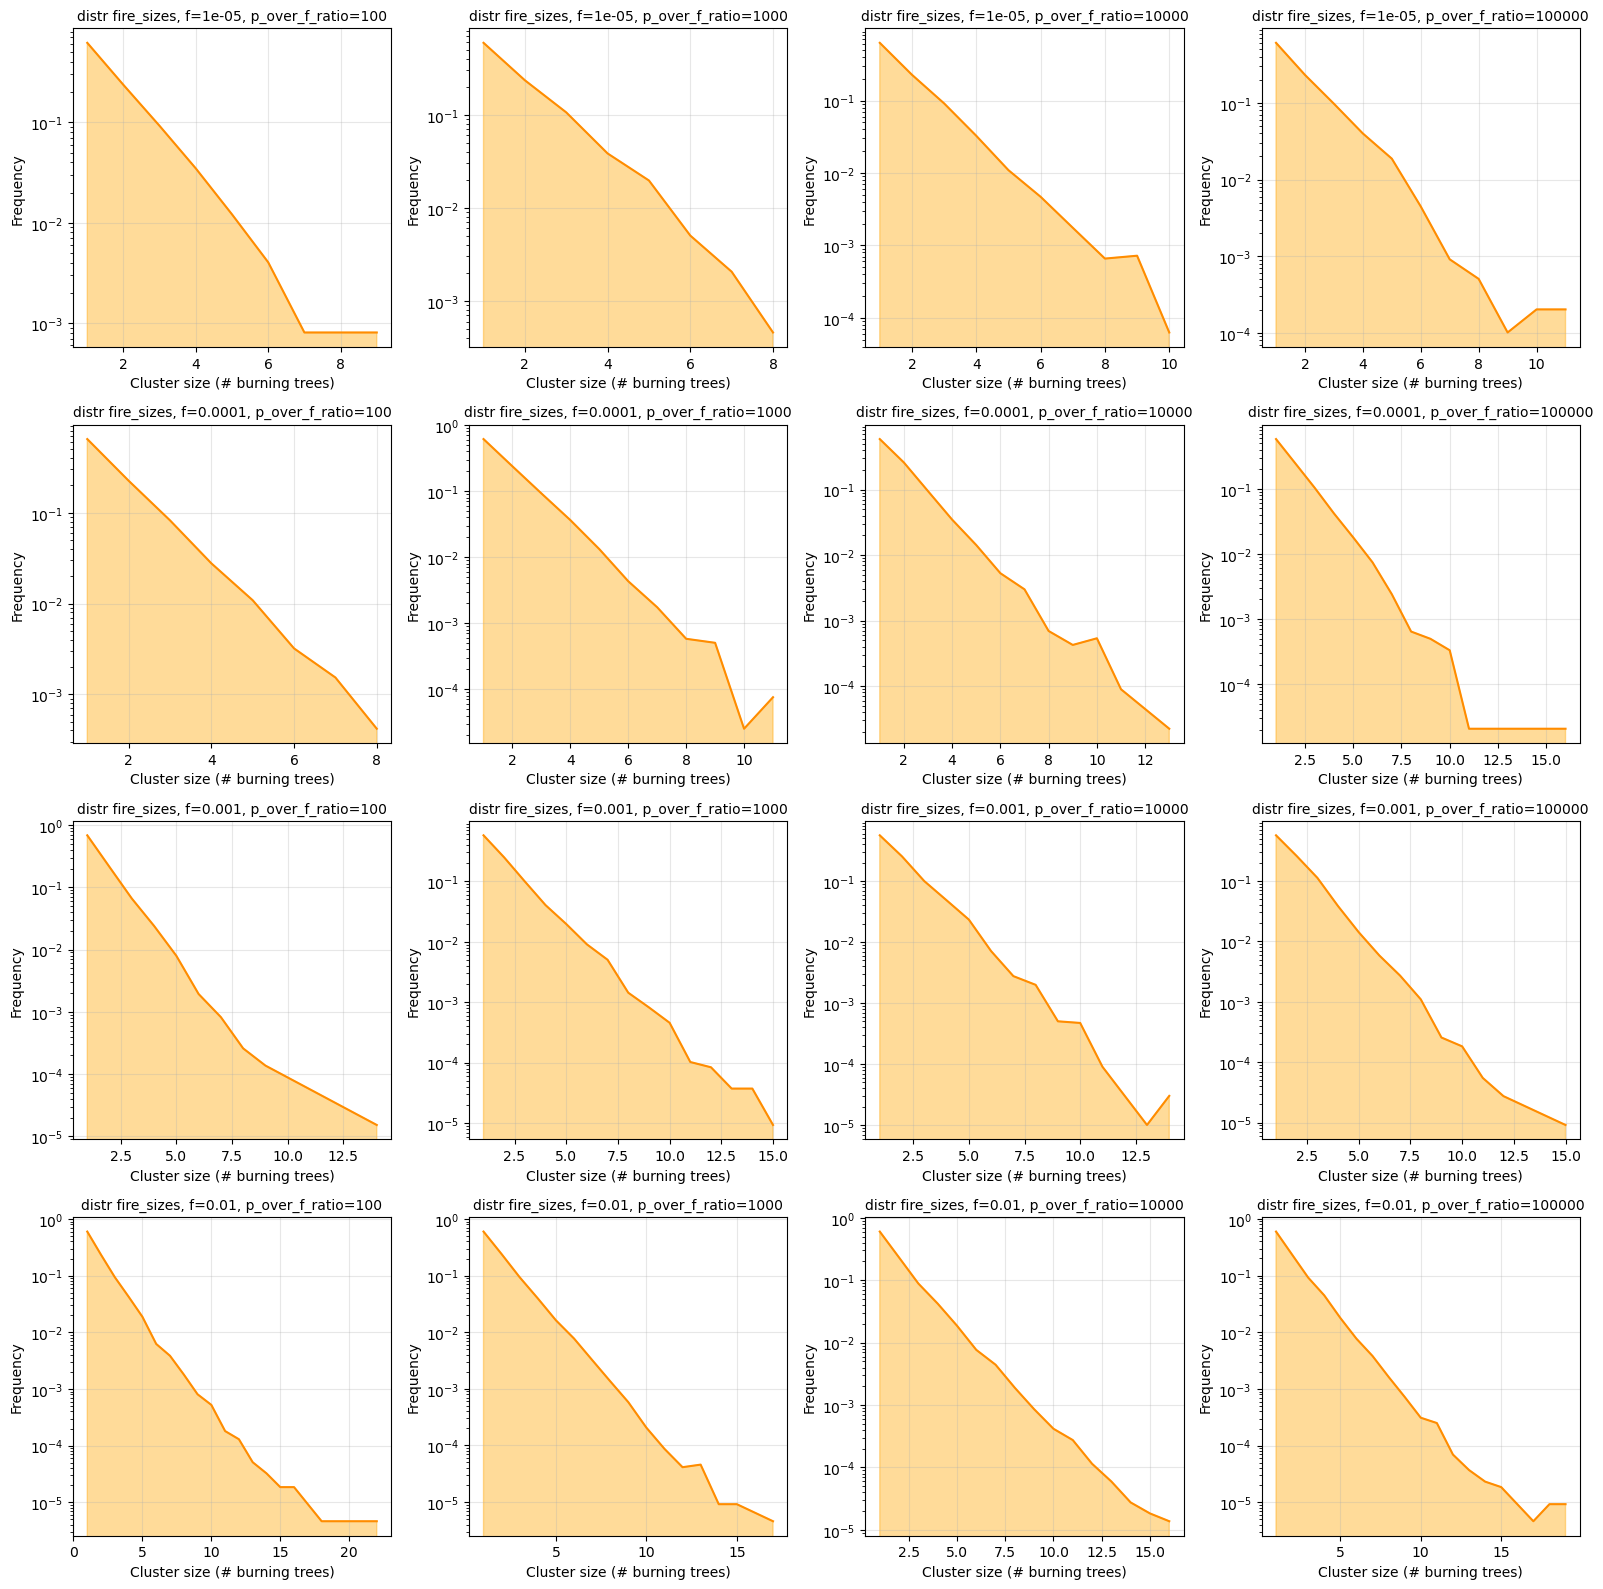

In [75]:
import matplotlib.pyplot as plt
import numpy as np


parameters['steps'] = 2000
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
list_lightning = [0.00001, 0.0001, 0.001, 0.01]
list_p_over_f = [100, 1000, 10000, 100000]
for i, f in enumerate(list_lightning):
    for j, p in enumerate(list_p_over_f):

        ax = axs[i, j]  # select subplot
        parameters['probability of lightning'] = f
        parameters['p_over_f'] = p
        model = ForestModel(parameters)
        model.run()

        all_sizes = np.concatenate(model.cluster_size)  # flatten nested arrays
        all_sizes = all_sizes[all_sizes > 0]  # remove zeros if any
        # Sort sizes and get their frequencies
        values, counts = np.unique(all_sizes, return_counts=True)
        prob = counts / counts.sum()
    
        ax.fill_between(values, prob, color='orange', alpha=0.4)
        ax.plot(values, prob, color='darkorange', lw=1.5)
        ax.set_title(f"distr fire_sizes, f={f}, p_over_f_ratio={p}", fontsize=10)
        ax.set_xlabel('Cluster size (# burning trees)')
        ax.set_ylabel('Frequency')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()





Completed: 2000 steps
Run time: 0:00:07.369786
Simulation finished
Completed: 2000 steps
Run time: 0:00:07.729030
Simulation finished
Completed: 2000 steps
Run time: 0:00:07.912641
Simulation finished
Completed: 2000 steps
Run time: 0:00:06.901392
Simulation finished


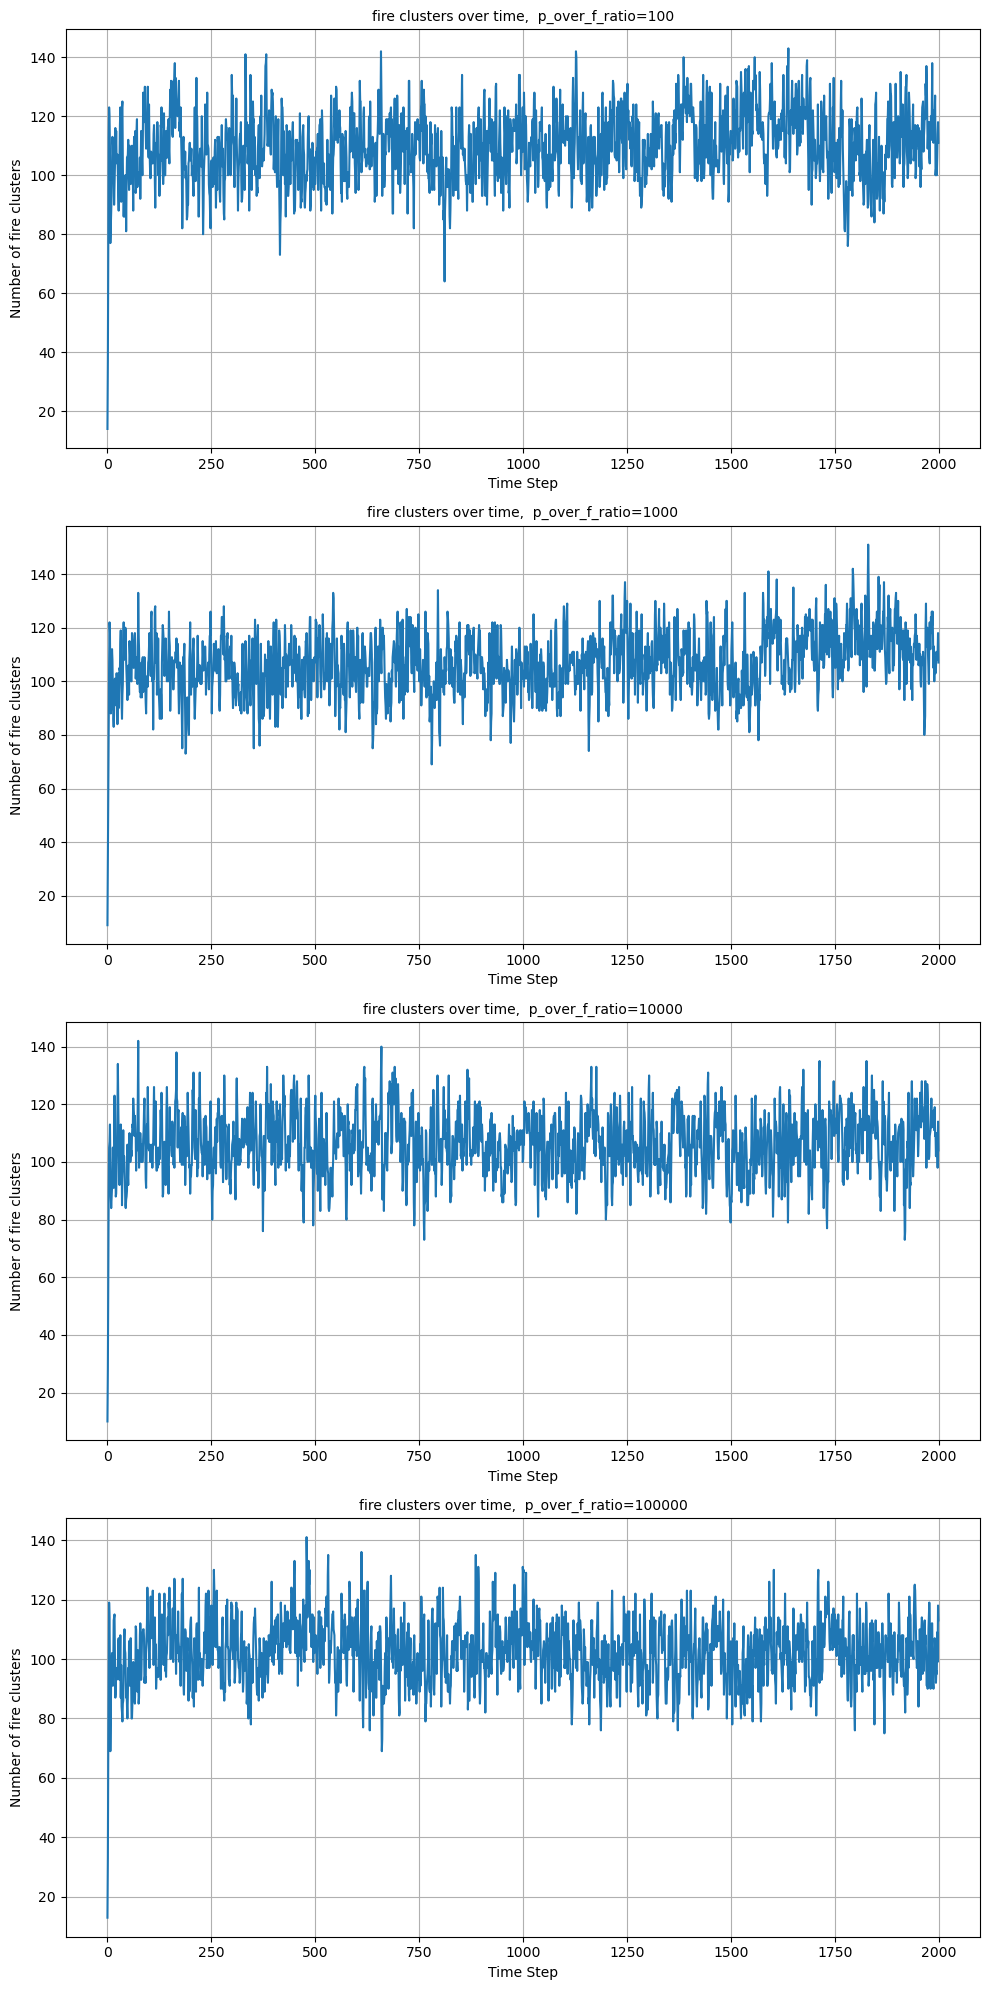

In [59]:
import matplotlib.pyplot as plt
parameters['steps'] = 2000

list_p_over_f = [100, 1000, 10000, 100000]
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

for i,p in enumerate(list_p_over_f):
    parameters['p_over_f'] = p
    model = ForestModel(parameters)
    model.run()
    ax = axs[i]


    ax.plot(model.cluster_counts)
    ax.set_title(f"fire clusters over time,  p_over_f_ratio={p}", fontsize=10)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Number of fire clusters")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Create single-run animation with custom colors
parameters['steps'] = 200
parameters['probability of lightning'] = 0.0001
parameters['p_over_f'] = 100

def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents.select(model.agents.condition == 0))}")

def animation_plot_values(model):
    time_steps = []
    attr_grid = model.forest.attr_grid('condition')
    model.tree_counts.append(len(model.agents.select(model.agents.condition == 0)))
    return time_steps, model.tree_counts


fig, ax = plt.subplots()
model = ForestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))


Completed: 200 steps
Run time: 0:00:00.278924
Simulation finished
Completed: 200 steps
Run time: 0:00:00.354846
Simulation finished
Completed: 200 steps
Run time: 0:00:00.336175
Simulation finished
Completed: 200 steps
Run time: 0:00:00.378508
Simulation finished
Completed: 200 steps
Run time: 0:00:00.400421
Simulation finished
Completed: 200 steps
Run time: 0:00:00.576837
Simulation finished
Completed: 200 steps
Run time: 0:00:00.511654
Simulation finished
Completed: 200 steps
Run time: 0:00:00.412391
Simulation finished
Completed: 200 steps
Run time: 0:00:00.476606
Simulation finished
Completed: 200 steps
Run time: 0:00:00.740043
Simulation finished
Completed: 200 steps
Run time: 0:00:01.362462
Simulation finished
Completed: 200 steps
Run time: 0:00:00.666640
Simulation finished
Completed: 200 steps
Run time: 0:00:01.195456
Simulation finished
Completed: 200 steps
Run time: 0:00:01.096844
Simulation finished
Completed: 200 steps
Run time: 0:00:00.994183
Simulation finished
Completed:

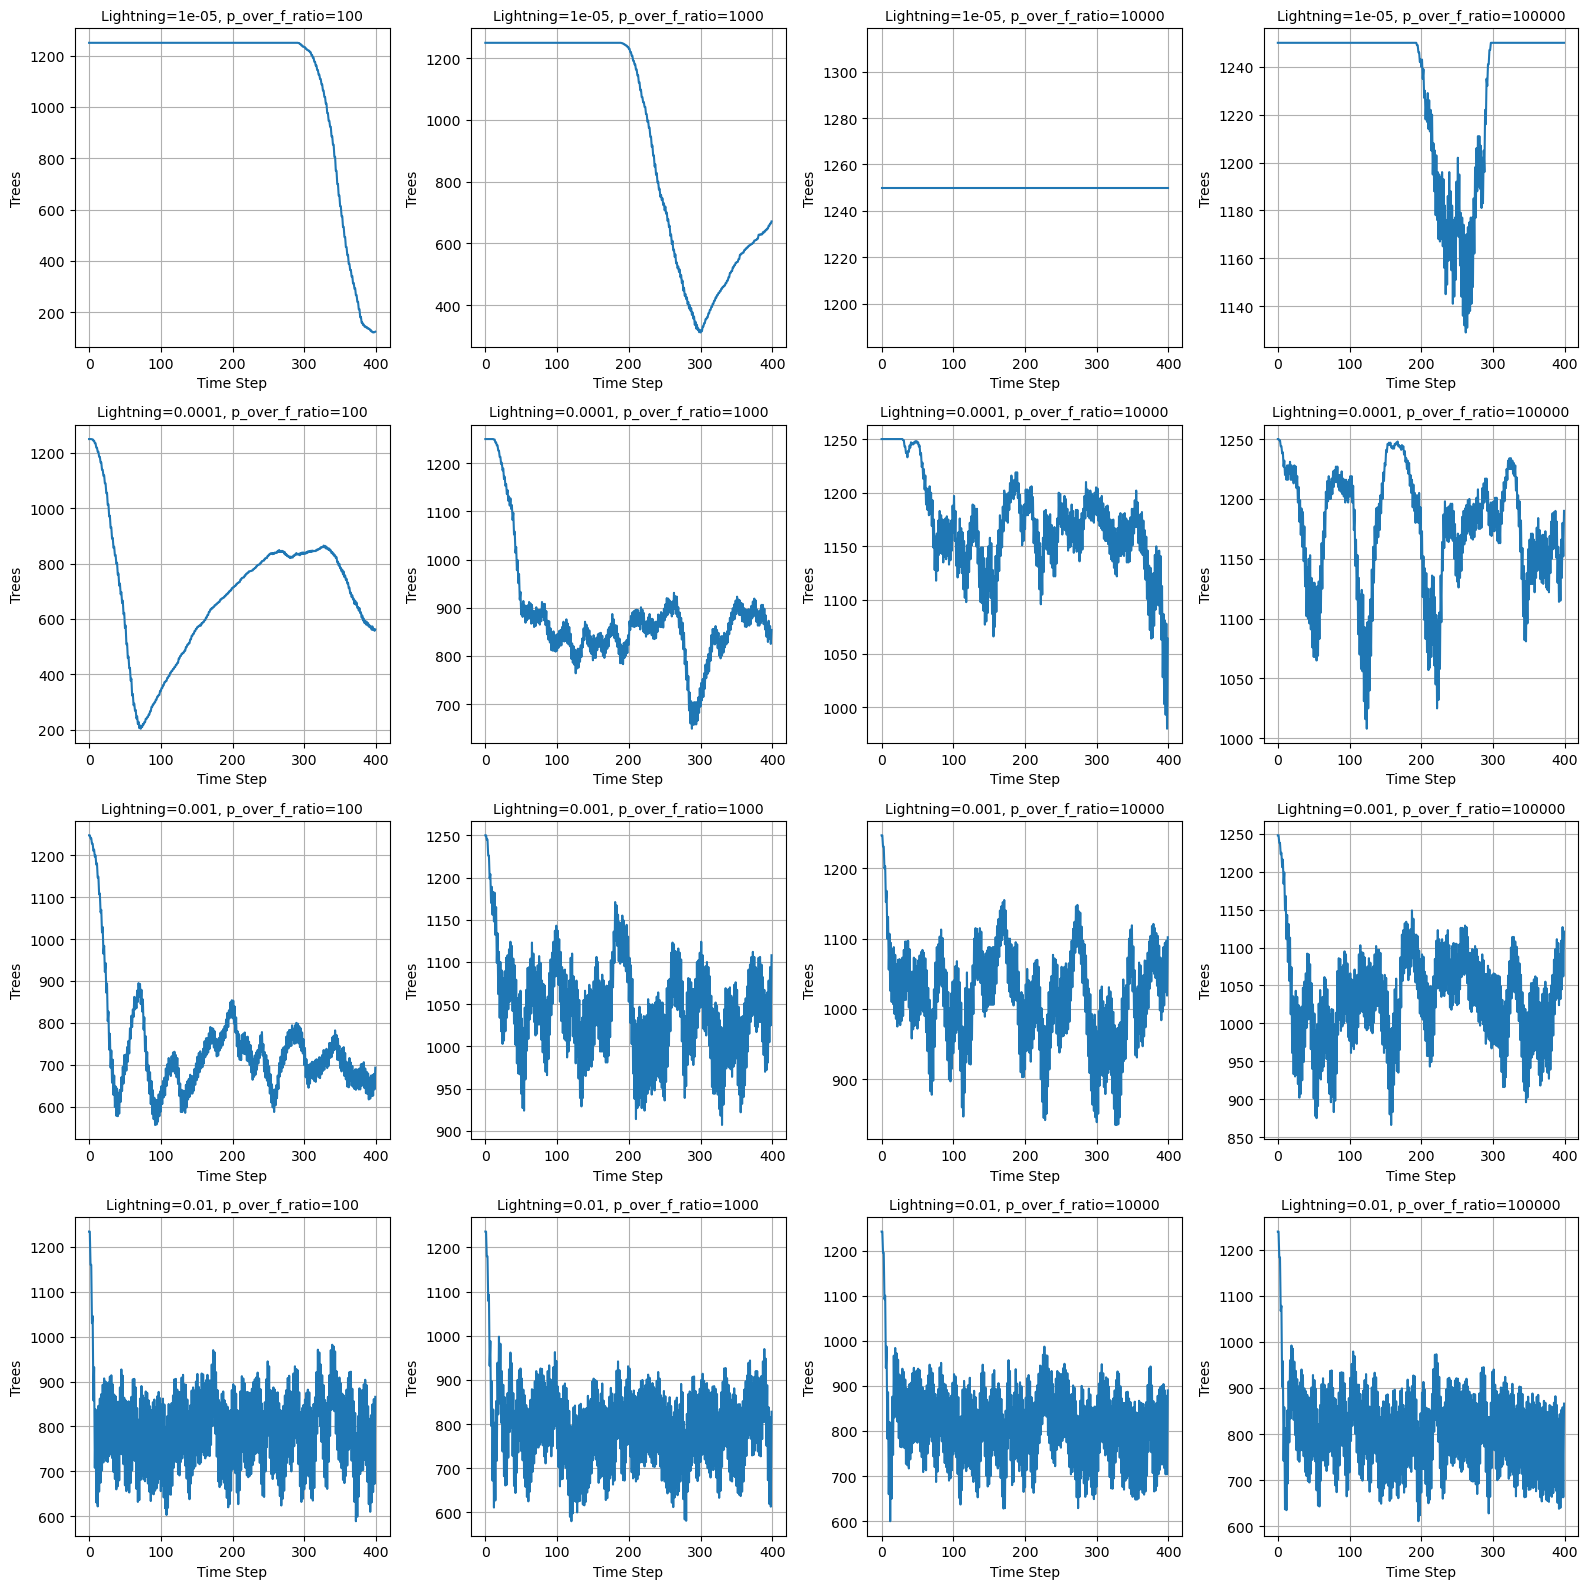

In [ ]:
import matplotlib.pyplot as plt
parameters['steps'] = 200
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
list_lightning = [0.00001, 0.0001, 0.001, 0.01]
list_p_over_f = [100, 1000, 10000, 100000]
for i, f in enumerate(list_lightning):
    for j, p in enumerate(list_p_over_f):
        ax = axs[i, j]  # select subplot
        parameters['probability of lightning'] = f
        parameters['p_over_f'] = p
        model = ForestModel(parameters)
        model.run()
    
        ax.plot(model.tree_counts)
        ax.set_title(f"Lightning={f}, p_over_f_ratio={p}", fontsize=10)
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Trees")
        ax.grid(True)

plt.tight_layout()
plt.show()
